In [ ]:
from datetime import datetime
import MetaTrader5 as mt5
import numpy as np
from numpy import savez_compressed

MAX_DATA_LENGTH = 1000000
MT5_CHUNK_SIZE = 10000
INPUT_STARTDATE = datetime(2020, 10, 15, 19)
INPUT_TIMEFRAME = mt5.TIMEFRAME_M15
INPUT_SYMBOL = 'EURUSD_small'


mt5.initialize()

rates = mt5.copy_rates_from(INPUT_SYMBOL, INPUT_TIMEFRAME, INPUT_STARTDATE, MT5_CHUNK_SIZE)
err = mt5.last_error()

mt5.shutdown()

if err[0] == mt5.RES_S_OK:
    savez_compressed(INPUT_SYMBOL + '_' + str(mt5.TIMEFRAME_M15) + '_' + str(len(rates)) + '.npz', rates)
    print('DONE', len(rates))
else:
    print('ERROR', err)



In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# tf.debugging.set_log_device_placement(True)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure as mpfg
import mplfinance as mpf

from numpy import load
# load dict of arrays
dict_data = load('EURUSD.npz')
data=dict_data['m15']
# data=rates


def _return(d: pd.Series):
    return d.iloc[-1] * 100 / d.iloc[0] - 100


def _diff(d: pd.Series):
    return (d.iloc[-1]-d.iloc[0])/2


df = pd.DataFrame(data).loc[:, ['time', 'open', 'high', 'low', 'close', 'tick_volume']]
# df = df.rename(columns={'time': 'Time', 'high': 'High', 'low': 'Low',
#                         'close': 'Close', 'tick_volume': 'Volume', 'open': 'Open'})

df = df.copy()
df['Diff1'] = df['close'].rolling(2).apply(_return)
df['HeightTight'] = df['close'] - df['open']
df['HeightLoose'] = df['high'] - df['low']
df['HeightRate'] = df['HeightTight'] / df['HeightLoose']
df['Diff5'] = df['close'].rolling(2).apply(_return)
for i in range(0,4):
    df['Diff5'] = df['Diff5'].rolling(2).apply(_diff)

df=df.dropna()

day = 24*60*60
week = 7 * day
year = (365.2425)*day

df['Day sin'] = np.sin(df['time'] * (2 * np.pi / day))
df['Day cos'] = np.cos(df['time'] * (2 * np.pi / day))
df['Week sin'] = np.sin(df['time'] * (2 * np.pi / week))
df['Week cos'] = np.cos(df['time'] * (2 * np.pi / week))
df['Year sin'] = np.sin(df['time'] * (2 * np.pi / year))
df['Year cos'] = np.cos(df['time'] * (2 * np.pi / year))

df = df.drop(columns=['time','open','close','high','low','tick_volume'])

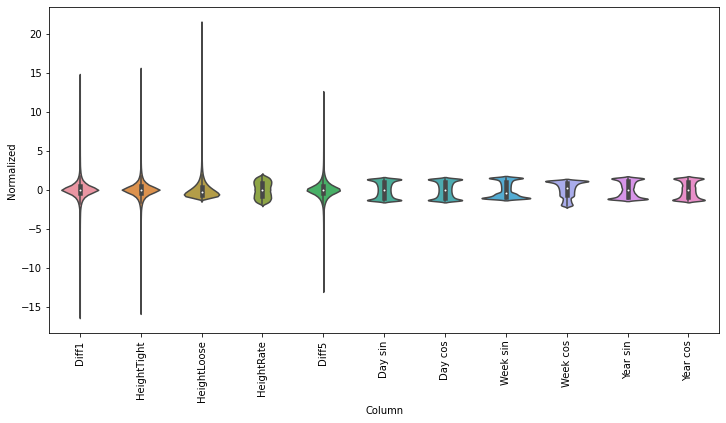

In [3]:

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [5]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
# tf.test.gpu_device_name()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:


MAX_EPOCHS = 20
LABEL_WIDTH = 96

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

wide_window = WindowGenerator(
    input_width=LABEL_WIDTH, label_width=LABEL_WIDTH, shift=1,
    label_columns=['Diff1'])


history = compile_and_fit(lstm_model, wide_window)

val_performance = {}
performance = {}

# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)


Epoch 1/20
1747/1747 [==============================] - 17s 9ms/step - loss: 1.0067 - mean_absolute_error: 0.6613 - val_loss: 1.6120 - val_mean_absolute_error: 0.7674
Epoch 2/20
1747/1747 [==============================] - 17s 10ms/step - loss: 1.0011 - mean_absolute_error: 0.6590 - val_loss: 1.6119 - val_mean_absolute_error: 0.7675
Epoch 3/20
1747/1747 [==============================] - 26s 15ms/step - loss: 0.9996 - mean_absolute_error: 0.6584 - val_loss: 1.6113 - val_mean_absolute_error: 0.7675
Epoch 4/20
1747/1747 [==============================] - 39s 22ms/step - loss: 0.9985 - mean_absolute_error: 0.6581 - val_loss: 1.6121 - val_mean_absolute_error: 0.7676
Epoch 5/20
497/497 [==============================] - 5s 10ms/step - loss: 1.6151 - mean_absolute_error: 0.7681


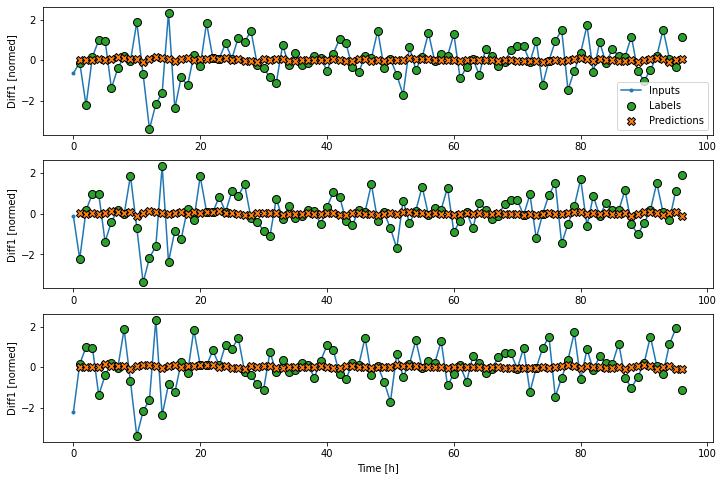

In [5]:

wide_window.plot(lstm_model, plot_col='Diff1')

In [ ]:
# print(wide_window.test)

# # pdt.shape
# print(wide_window.test_df)
ttt = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=wide_window.test_df.iloc[0:96],
      targets=None,
      sequence_length=97,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)
# print(ttt)
tttt = ttt.map(wide_window.split_window)
pdt = lstm_model.predict(tttt)
# wide_window.test
# wide_window.split_window
# wide_window.total_window_size
# print(wide_window.test_df.iloc[0:96])
# pdt

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.figure as mpfg
import mplfinance as mpf


df_test = test_df.copy()
df_test['Time'] = pd.to_datetime(np.array(data['time'][-len(df_test):]), unit='s')
df_test = df_test.set_index('Time')

pdt = lstm_model.predict(wide_window.test)
nnn = np.empty(96)
nnn.fill(np.nan)

aaa = np.concatenate((nnn,pdt[0,:,0]))

wide_window.test.

dp = df_test[:192]
xxx=aaa[:192]
apds = [
    mpf.make_addplot(dp['Diff1'], panel=1, color='lightblue', secondary_y=False),
    mpf.make_addplot(xxx, panel=1, color='red', secondary_y=False),
]

fig, axes = mpf.plot(dp, addplot=apds, figratio=(24, 10), type='candle', style='nightclouds', volume=False,
                     datetime_format='%Y-%m-%d %H:%M', xrotation=90, tight_layout=True, returnfig=True)
axes[0].locator_params(nbins=50, axis='x')
plt.show()

In [10]:
LABEL_WIDTH = 32
CONV_WIDTH = 6
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Diff1'])

conv_model = tf.keras.Sequential([ 
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
history = compile_and_fit(conv_model, wide_conv_window)


Epoch 1/20
174/174 [==============================] - 1s 4ms/step - loss: 1.0358 - mean_absolute_error: 0.7146 - val_loss: 0.8739 - val_mean_absolute_error: 0.6672
Epoch 2/20
174/174 [==============================] - 0s 2ms/step - loss: 0.9926 - mean_absolute_error: 0.6993 - val_loss: 0.8698 - val_mean_absolute_error: 0.6632
Epoch 3/20
174/174 [==============================] - 0s 2ms/step - loss: 0.9752 - mean_absolute_error: 0.6937 - val_loss: 0.8711 - val_mean_absolute_error: 0.6634
Epoch 4/20
174/174 [==============================] - 0s 2ms/step - loss: 0.9680 - mean_absolute_error: 0.6941 - val_loss: 0.8764 - val_mean_absolute_error: 0.6678


49/49 [==============================] - 0s 2ms/step - loss: 0.8764 - mean_absolute_error: 0.6678


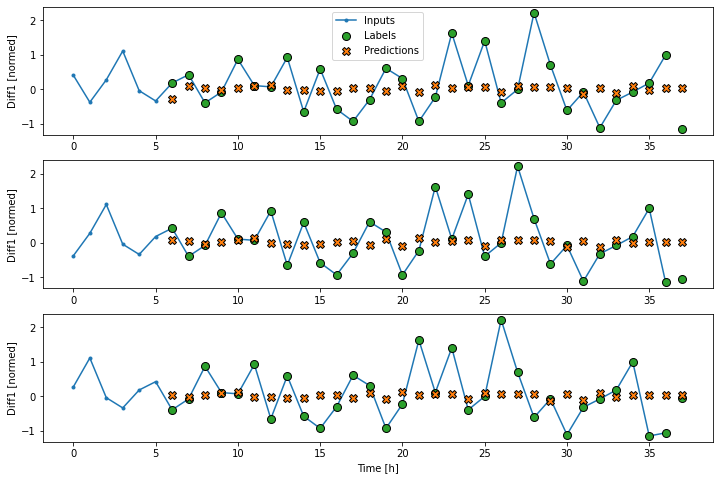

In [11]:

# IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(wide_conv_window.val)
performance['Conv'] = conv_model.evaluate(wide_conv_window.test, verbose=0)

wide_conv_window.plot(conv_model, plot_col='Diff1')

# wide_window.plot(lstm_model, plot_col='Close')
# performance


In [ ]:

import matplotlib.pyplot as plt
import matplotlib.figure as mpfg
import mplfinance as mpf


df_test = test_df.copy()
df_test['Time'] = pd.to_datetime(np.array(data['time'][-len(df_test):]), unit='s')
df_test = df_test.set_index('Time')

pdt = conv_model.predict(wide_conv_window.test)
nnn = np.empty(37)
nnn.fill(np.nan)

aaa = np.concatenate((nnn,pdt[:,0,0]))

dp = df_test[:192]
xxx=aaa[:192]
apds = [
    mpf.make_addplot(dp['Diff1'], panel=1, color='lightblue', secondary_y=False),
    mpf.make_addplot(xxx, panel=1, color='red', secondary_y=False),
]

fig, axes = mpf.plot(dp, addplot=apds, figratio=(24, 10), type='candle', style='nightclouds', volume=False,
                     datetime_format='%Y-%m-%d %H:%M', xrotation=90, tight_layout=True, returnfig=True)
axes[0].locator_params(nbins=50, axis='x')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.figure as mpfg
import mplfinance as mpf


df['Time'] = pd.to_datetime(df['Time'], unit='s')
df = df.set_index('Time')


dp = df[:500]
apds = [
    mpf.make_addplot(dp['Diff1'], panel=1, color='lightblue', secondary_y=False),
    mpf.make_addplot(dp['Diff10'], panel=2, color='lightblue', secondary_y=False),
    mpf.make_addplot(dp['Diff20'], panel=3, color='lightblue', secondary_y=False),
    mpf.make_addplot(dp['Diff30'], panel=4, color='lightblue', secondary_y=False),
]

fig, axes = mpf.plot(dp, addplot=apds, figratio=(24, 10), type='line', style='nightclouds', volume=False,
                     datetime_format='%Y-%m-%d %H:%M', xrotation=90, tight_layout=True, returnfig=True)
axes[0].locator_params(nbins=50, axis='x')
plt.show()

In [ ]:
df.describe().transpose()

In [ ]:
plt.hist2d(df['HeightTight'], df['HeightLoose'], bins=(50, 50))
plt.colorbar()